In [10]:
import pickle
from glob import glob
import os
from matplotlib import gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import yaml
from math import sqrt
import random
from tqdm.notebook import tqdm
from math import ceil
from itertools import product
from matplotlib.patches import Polygon
from multiprocessing import Process
from itertools import product

def Bootstrap(Loss):
    mean_list = []
    for i in range(1000):
        choiceLIst = [random.choice(Loss) for i in range(180)]
        mean = np.array(choiceLIst).mean()
        mean_list.append(mean)
    mean_list = sorted(mean_list)
    M0 = mean_list[25]
    M1 = mean_list[975]
    return M0, M1

In [11]:
loss = np.ones((3,5,4,4,15)) #sigma, train, algo, V, graph
error_min = np.ones((3,5,4,4,15))
error_max = np.ones((3,5,4,4,15))
EPS = float(np.finfo(np.float64).eps)
node = 0

train_list = [
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___",
    
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___",
    
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___",
"/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___"   
]

a = "0."
count = 1
plt.figure(figsize = (28,15))
for _ in tqdm(train_list, desc="outer"):
    test_list = []
    for i,k,j in product(['TorchGNN', 'Belief', 'MeanField', 'TreeReWeighted'], ['_path_{}'.format(a),'_binarytree_{}'.format(a), '_cycle_{}'.format(a), '_grid_{}'.format(a), '_circladder_{}'.format(a), '_ladder_{}'.format(a), '_cylinder_{}'.format(a), '_torus_{}'.format(a), '_trikite_{}'.format(a), '_trilattice_{}'.format(a), '_trigrid_{}'.format(a), '_barbell2_{}'.format(a), '_barbell_{}'.format(a), '_bipartite_{}'.format(a), '_complete_{}'.format(a)], ['16_16_64', '16_36_64', '16_64_64', '16_100_64']):
        for __ in os.listdir(_):
            if i in __ and k in __ and str(j) in __:

                test_list.append(os.path.join(_, __))        
                break

    for idx, ___ in tqdm(enumerate(test_list), leave=False, desc='Inner'):
        for file in os.listdir(___):
            if 'gt_pts' in file:
                path = os.path.join(___, file)
                p = pd.read_csv(path, sep='\t', header=None).values

            elif 'pred_pts' in file:
                path = os.path.join(___, file)
                q = pd.read_csv(path, sep='\t', header=None).values

#             if "MeanField" in ___:
        q = (q+EPS)/(q+EPS).sum(axis = 1).reshape(-1,1)

        P = torch.Tensor(p).type(dtype=torch.float64)
        Q = torch.Tensor(q).type(dtype=torch.float64)
        
#         plt.subplot(8,15,count)
#         plt.title("{:0.2e}".format(nn.KLDivLoss(reduction = 'batchmean')(torch.log(Q), P)), fontsize=3)
#         plt.scatter(P[:,0],Q[:,0], s=5, color='blue')
#         plt.xlim(0,1)
#         plt.ylim(0,1)
#         plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'k-', lw=0.3)
#         count += 1

        var_ = nn.KLDivLoss(reduction = 'none')(torch.log(Q), P).sum(dim=1)

        var_[np.where(var_ <= 0)] = EPS
        Min, Max = Bootstrap(np.log10(var_))
        mean_loss = np.log10(var_).mean()
        Min, Max = mean_loss-Min, Max-mean_loss

        if 'nan' in str(Min) or 'inf' in str(Min):
            print(___)
            print(Min, Max, mean_loss)

        elif 'nan' in str(Min) or 'inf' in str(Max):
            print(___)
            print(Min, Max, mean_loss)

        elif 'nan' in str(mean_loss) or 'inf' in str(mean_loss):
            print(___)
            print(Min, Max, mean_loss)

        #sigma, algo, V, graph  
        if "0.3" in ___:
            sigma = 0
        elif "0.6" in ___:
            sigma = 1
        elif "0.9" in ___:
            sigma = 2
            
        if "16_16" in ___:
            node = 0
        elif "16_36" in ___:
            node = 1
        elif "16_64" in ___:
            node = 2
        elif "16_100" in ___:
            node = 3

        if "BeliefPropagation" in ___:
            algo = 1
        elif "MeanField" in ___:
            algo = 2
        elif "TreeReWeighted" in ___:
            algo = 3
        else:
            algo = 0

        if "_path_{}".format(a) in ___:
            graph = 0
        elif "_binarytree_{}".format(a) in ___:
            graph = 1
        elif "_cycle_{}".format(a) in ___:
            graph = 2
        elif "_grid_{}".format(a) in ___:
            graph = 3
        elif "_circladder_{}".format(a) in ___:
            graph = 4
        elif "_ladder_{}".format(a) in ___:
            graph = 5
        elif "_cylinder_{}".format(a) in ___:
            graph = 6
        elif "_torus_{}".format(a) in ___:
            graph = 7
        elif "_trikite_{}".format(a) in ___:
            graph = 8
        elif "_trilattice_{}".format(a) in ___:
            graph = 9
        elif "_trigrid_{}".format(a) in ___:
            graph = 10
        elif "_barbell2_{}".format(a) in ___:
            graph = 11
        elif "_barbell_{}".format(a) in ___:
            graph = 12
        elif "_bipartite_{}".format(a) in ___:
            graph = 13
        elif "_complete_{}".format(a) in ___:
            graph = 14

        if "train_16_binarytree" in ___:
            train = 0
        elif "train_16_grid" in ___:
            train = 1
        elif "train_16_trigrid" in ___:
            train = 2
        elif "train_16_bipartite" in ___:
            train = 3
        elif "train_16_all":
            train = 4
            
#         print(___, 0,0,algo,node,graph)

        #sigma, train, algo, V, graph
        print(___)
        print(sigma, train, algo, node, graph, mean_loss, Min, Max)
        if loss[sigma,train,algo,node,graph] == 1:
            loss[sigma,train,algo,node,graph] = mean_loss
        else:
            print("Error")
            print(asfd)
            
        if error_min[sigma,train,algo,node,graph] == 1: 
            error_min[sigma,train,algo,node,graph] = Min
        else:
            print("Error")
            print(asfd)
            
        if error_max[sigma,train,algo,node,graph] == 1:
            error_max[sigma,train,algo,node,graph] = Max
        else:
            print("Error")
            print(asfd)


/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-29-23_path_0.3_16_16_64_10_add___
0 0 0 0 0 tensor(-9.3964, dtype=torch.float64) tensor(0.5591, dtype=torch.float64) tensor(0.5081, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-46-42_path_0.3_16_36_64_10_add___
0 0 0 1 0 tensor(-4.7770, dtype=torch.float64) tensor(0.2204, dtype=torch.float64) tensor(0.1759, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-03-49_path_0.3_16_64_64_10_add___
0 0 0 2 0 tensor(-4.7293, dtype=torch.float64) tensor(0.1953, dtype=torc

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-36-20_cylinder_0.3_16_16_64_10_add___
0 0 0 0 6 tensor(-7.4543, dtype=torch.float64) tensor(0.3840, dtype=torch.float64) tensor(0.3784, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-53-35_cylinder_0.3_16_36_64_10_add___
0 0 0 1 6 tensor(-4.7532, dtype=torch.float64) tensor(0.1874, dtype=torch.float64) tensor(0.1760, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-10-38_cylinder_0.3_16_64_64_10_add___
0 0 0 2 6 tensor(-4.8016, dtype=torch.float64) tensor(0.1694

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-43-13_barbell_0.3_16_16_64_10_add___
0 0 0 0 12 tensor(-4.6769, dtype=torch.float64) tensor(0.1466, dtype=torch.float64) tensor(0.1526, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-00-23_barbell_0.3_16_36_64_10_add___
0 0 0 1 12 tensor(-2.0523, dtype=torch.float64) tensor(0.1482, dtype=torch.float64) tensor(0.1359, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-17-26_barbell_0.3_16_64_64_10_add___
0 0 0 2 12 tensor(-1.7400, dtype=torch.float64) tensor(0.1473

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-29-22_path_0.3_16_16_64_10_add___
0 1 0 0 0 tensor(-8.2487, dtype=torch.float64) tensor(0.4364, dtype=torch.float64) tensor(0.3864, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-46-34_path_0.3_16_36_64_10_add___
0 1 0 1 0 tensor(-4.7753, dtype=torch.float64) tensor(0.2099, dtype=torch.float64) tensor(0.1920, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-03-46_path_0.3_16_64_64_10_add___
0 1 0 2 0 tensor(-4.6874, dtype=torch.float64) tensor(0.1543, dtype=torch.float64) tensor(

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-36-19_cylinder_0.3_16_16_64_10_add___
0 1 0 0 6 tensor(-7.0477, dtype=torch.float64) tensor(0.3531, dtype=torch.float64) tensor(0.2928, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-53-30_cylinder_0.3_16_36_64_10_add___
0 1 0 1 6 tensor(-4.7609, dtype=torch.float64) tensor(0.1872, dtype=torch.float64) tensor(0.1693, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-10-41_cylinder_0.3_16_64_64_10_add___
0 1 0 2 6 tensor(-4.8306, dtype=torch.float64) tensor(0.2059, dtype=torch.floa

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-43-07_barbell_0.3_16_16_64_10_add___
0 1 0 0 12 tensor(-4.6215, dtype=torch.float64) tensor(0.2006, dtype=torch.float64) tensor(0.1943, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-00-19_barbell_0.3_16_36_64_10_add___
0 1 0 1 12 tensor(-1.5761, dtype=torch.float64) tensor(0.1500, dtype=torch.float64) tensor(0.1439, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-35_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-17-32_barbell_0.3_16_64_64_10_add___
0 1 0 2 12 tensor(-1.3570, dtype=torch.float64) tensor(0.1361, dtype=torch.floa

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-29-23_path_0.3_16_16_64_10_add___
0 2 0 0 0 tensor(-7.2964, dtype=torch.float64) tensor(0.3395, dtype=torch.float64) tensor(0.3123, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-46-27_path_0.3_16_36_64_10_add___
0 2 0 1 0 tensor(-4.7748, dtype=torch.float64) tensor(0.2100, dtype=torch.float64) tensor(0.1650, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-03-47_path_0.3_16_64_64_10_add___
0 2 0 2 0 tensor(-4.7204, dtype=torch.float64) tensor(0.2073, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-36-12_cylinder_0.3_16_16_64_10_add___
0 2 0 0 6 tensor(-6.5540, dtype=torch.float64) tensor(0.3837, dtype=torch.float64) tensor(0.3218, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-53-27_cylinder_0.3_16_36_64_10_add___
0 2 0 1 6 tensor(-4.7835, dtype=torch.float64) tensor(0.2507, dtype=torch.float64) tensor(0.2128, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-10-42_cylinder_0.3_16_64_64_10_add___
0 2 0 2 6 tensor(-4.7769, dtype=torch.float64) tensor(0.1857, dtype=t

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-43-02_barbell_0.3_16_16_64_10_add___
0 2 0 0 12 tensor(-5.2143, dtype=torch.float64) tensor(0.2719, dtype=torch.float64) tensor(0.2420, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-00-20_barbell_0.3_16_36_64_10_add___
0 2 0 1 12 tensor(-1.6842, dtype=torch.float64) tensor(0.1503, dtype=torch.float64) tensor(0.1489, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-36_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-17-32_barbell_0.3_16_64_64_10_add___
0 2 0 2 12 tensor(-1.4337, dtype=torch.float64) tensor(0.1361, dtype=t

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-29-23_path_0.3_16_16_64_10_add___
0 3 0 0 0 tensor(-2.8725, dtype=torch.float64) tensor(0.1219, dtype=torch.float64) tensor(0.1106, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-46-32_path_0.3_16_36_64_10_add___
0 3 0 1 0 tensor(-2.9618, dtype=torch.float64) tensor(0.1345, dtype=torch.float64) tensor(0.1316, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-03-44_path_0.3_16_64_64_10_add___
0 3 0 2 0 tensor(-2.8132, dtype=torch.float64) tensor(0.1250, dtype=torch.f

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-36-12_cylinder_0.3_16_16_64_10_add___
0 3 0 0 6 tensor(-3.0365, dtype=torch.float64) tensor(0.1295, dtype=torch.float64) tensor(0.1102, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-53-26_cylinder_0.3_16_36_64_10_add___
0 3 0 1 6 tensor(-3.2063, dtype=torch.float64) tensor(0.1211, dtype=torch.float64) tensor(0.1166, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-10-39_cylinder_0.3_16_64_64_10_add___
0 3 0 2 6 tensor(-3.2316, dtype=torch.float64) tensor(0.1454, d

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-43-02_barbell_0.3_16_16_64_10_add___
0 3 0 0 12 tensor(-4.5228, dtype=torch.float64) tensor(0.2551, dtype=torch.float64) tensor(0.2017, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-00-17_barbell_0.3_16_36_64_10_add___
0 3 0 1 12 tensor(-2.6028, dtype=torch.float64) tensor(0.1443, dtype=torch.float64) tensor(0.1369, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-39_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-17-31_barbell_0.3_16_64_64_10_add___
0 3 0 2 12 tensor(-1.3763, dtype=torch.float64) tensor(0.1829, d

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-29-23_path_0.3_16_16_64_10_add___
0 4 0 0 0 tensor(-7.8375, dtype=torch.float64) tensor(0.4440, dtype=torch.float64) tensor(0.4204, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-46-27_path_0.3_16_36_64_10_add___
0 4 0 1 0 tensor(-4.8158, dtype=torch.float64) tensor(0.2524, dtype=torch.float64) tensor(0.1881, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-03-37_path_0.3_16_64_64_10_add___
0 4 0 2 0 tensor(-4.7206, dtype=torch.float64) tensor(0.1666, dtype=torch.float64) tensor(0.1

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-36-14_cylinder_0.3_16_16_64_10_add___
0 4 0 0 6 tensor(-6.5096, dtype=torch.float64) tensor(0.3173, dtype=torch.float64) tensor(0.2564, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-53-22_cylinder_0.3_16_36_64_10_add___
0 4 0 1 6 tensor(-4.7089, dtype=torch.float64) tensor(0.1656, dtype=torch.float64) tensor(0.1435, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-10-33_cylinder_0.3_16_64_64_10_add___
0 4 0 2 6 tensor(-4.7598, dtype=torch.float64) tensor(0.1768, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-09-43-02_barbell_0.3_16_16_64_10_add___
0 4 0 0 12 tensor(-4.9836, dtype=torch.float64) tensor(0.2174, dtype=torch.float64) tensor(0.1966, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-00-15_barbell_0.3_16_36_64_10_add___
0 4 0 1 12 tensor(-2.8236, dtype=torch.float64) tensor(0.1508, dtype=torch.float64) tensor(0.1465, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.3_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-42_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-10-17-22_barbell_0.3_16_64_64_10_add___
0 4 0 2 12 tensor(-1.4730, dtype=torch.float64) tensor(0.1446, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-07-45_path_0.6_16_16_64_10_add___
1 0 0 0 0 tensor(-7.3009, dtype=torch.float64) tensor(0.3166, dtype=torch.float64) tensor(0.3334, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-18-31_path_0.6_16_36_64_10_add___
1 0 0 1 0 tensor(-4.6390, dtype=torch.float64) tensor(0.2817, dtype=torch.float64) tensor(0.2188, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-29-23_path_0.6_16_64_64_10_add___
1 0 0 2 0 tensor(-4.5460, dtype=torch.float64) tensor(0.1901, dtype=torc

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-12-07_cylinder_0.6_16_16_64_10_add___
1 0 0 0 6 tensor(-4.8949, dtype=torch.float64) tensor(0.2398, dtype=torch.float64) tensor(0.2106, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-22-53_cylinder_0.6_16_36_64_10_add___
1 0 0 1 6 tensor(-4.2837, dtype=torch.float64) tensor(0.2267, dtype=torch.float64) tensor(0.1997, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-33-44_cylinder_0.6_16_64_64_10_add___
1 0 0 2 6 tensor(-4.3063, dtype=torch.float64) tensor(0.1977

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-16-20_barbell_0.6_16_16_64_10_add___
1 0 0 0 12 tensor(-2.5041, dtype=torch.float64) tensor(0.1399, dtype=torch.float64) tensor(0.1430, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-27-15_barbell_0.6_16_36_64_10_add___
1 0 0 1 12 tensor(-1.0815, dtype=torch.float64) tensor(0.1284, dtype=torch.float64) tensor(0.1237, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-45_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-38-04_barbell_0.6_16_64_64_10_add___
1 0 0 2 12 tensor(-0.8125, dtype=torch.float64) tensor(0.1320

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-07-45_path_0.6_16_16_64_10_add___
1 1 0 0 0 tensor(-6.3665, dtype=torch.float64) tensor(0.2680, dtype=torch.float64) tensor(0.2204, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-18-40_path_0.6_16_36_64_10_add___
1 1 0 1 0 tensor(-4.5796, dtype=torch.float64) tensor(0.2403, dtype=torch.float64) tensor(0.1988, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-29-27_path_0.6_16_64_64_10_add___
1 1 0 2 0 tensor(-4.5259, dtype=torch.float64) tensor(0.1791, dtype=torch.float64) tensor(

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-12-07_cylinder_0.6_16_16_64_10_add___
1 1 0 0 6 tensor(-4.7165, dtype=torch.float64) tensor(0.1424, dtype=torch.float64) tensor(0.1554, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-22-59_cylinder_0.6_16_36_64_10_add___
1 1 0 1 6 tensor(-4.3697, dtype=torch.float64) tensor(0.1665, dtype=torch.float64) tensor(0.1522, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-33-47_cylinder_0.6_16_64_64_10_add___
1 1 0 2 6 tensor(-4.3183, dtype=torch.float64) tensor(0.1906, dtype=torch.floa

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-16-29_barbell_0.6_16_16_64_10_add___
1 1 0 0 12 tensor(-3.0924, dtype=torch.float64) tensor(0.1611, dtype=torch.float64) tensor(0.1623, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-27-15_barbell_0.6_16_36_64_10_add___
1 1 0 1 12 tensor(-1.2522, dtype=torch.float64) tensor(0.1358, dtype=torch.float64) tensor(0.1283, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-48_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-38-08_barbell_0.6_16_64_64_10_add___
1 1 0 2 12 tensor(-0.8346, dtype=torch.float64) tensor(0.1191, dtype=torch.floa

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-07-45_path_0.6_16_16_64_10_add___
1 2 0 0 0 tensor(-5.4870, dtype=torch.float64) tensor(0.2581, dtype=torch.float64) tensor(0.1973, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-18-34_path_0.6_16_36_64_10_add___
1 2 0 1 0 tensor(-4.4554, dtype=torch.float64) tensor(0.2245, dtype=torch.float64) tensor(0.1854, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-29-23_path_0.6_16_64_64_10_add___
1 2 0 2 0 tensor(-4.4615, dtype=torch.float64) tensor(0.2090, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-12-03_cylinder_0.6_16_16_64_10_add___
1 2 0 0 6 tensor(-4.2639, dtype=torch.float64) tensor(0.1387, dtype=torch.float64) tensor(0.1414, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-22-53_cylinder_0.6_16_36_64_10_add___
1 2 0 1 6 tensor(-4.0606, dtype=torch.float64) tensor(0.2166, dtype=torch.float64) tensor(0.1868, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-33-44_cylinder_0.6_16_64_64_10_add___
1 2 0 2 6 tensor(-4.2272, dtype=torch.float64) tensor(0.2166, dtype=t

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-16-22_barbell_0.6_16_16_64_10_add___
1 2 0 0 12 tensor(-3.3327, dtype=torch.float64) tensor(0.1210, dtype=torch.float64) tensor(0.1156, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-27-13_barbell_0.6_16_36_64_10_add___
1 2 0 1 12 tensor(-1.3021, dtype=torch.float64) tensor(0.1179, dtype=torch.float64) tensor(0.1236, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-51_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-38-04_barbell_0.6_16_64_64_10_add___
1 2 0 2 12 tensor(-0.8537, dtype=torch.float64) tensor(0.1301, dtype=t

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-07-45_path_0.6_16_16_64_10_add___
1 3 0 0 0 tensor(-3.0027, dtype=torch.float64) tensor(0.2210, dtype=torch.float64) tensor(0.1925, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-18-34_path_0.6_16_36_64_10_add___
1 3 0 1 0 tensor(-2.7530, dtype=torch.float64) tensor(0.1256, dtype=torch.float64) tensor(0.1226, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-29-26_path_0.6_16_64_64_10_add___
1 3 0 2 0 tensor(-2.8120, dtype=torch.float64) tensor(0.1371, dtype=torch.f

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-12-05_cylinder_0.6_16_16_64_10_add___
1 3 0 0 6 tensor(-2.6641, dtype=torch.float64) tensor(0.1230, dtype=torch.float64) tensor(0.1246, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-22-56_cylinder_0.6_16_36_64_10_add___
1 3 0 1 6 tensor(-2.8223, dtype=torch.float64) tensor(0.1288, dtype=torch.float64) tensor(0.1257, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-33-42_cylinder_0.6_16_64_64_10_add___
1 3 0 2 6 tensor(-2.7741, dtype=torch.float64) tensor(0.1417, d

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-16-24_barbell_0.6_16_16_64_10_add___
1 3 0 0 12 tensor(-2.8272, dtype=torch.float64) tensor(0.1584, dtype=torch.float64) tensor(0.1443, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-27-15_barbell_0.6_16_36_64_10_add___
1 3 0 1 12 tensor(-1.4596, dtype=torch.float64) tensor(0.1329, dtype=torch.float64) tensor(0.1173, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-54_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-38-02_barbell_0.6_16_64_64_10_add___
1 3 0 2 12 tensor(-0.8686, dtype=torch.float64) tensor(0.1154, d

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-07-45_path_0.6_16_16_64_10_add___
1 4 0 0 0 tensor(-5.4308, dtype=torch.float64) tensor(0.1956, dtype=torch.float64) tensor(0.1760, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-18-32_path_0.6_16_36_64_10_add___
1 4 0 1 0 tensor(-4.3742, dtype=torch.float64) tensor(0.1794, dtype=torch.float64) tensor(0.1440, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-29-24_path_0.6_16_64_64_10_add___
1 4 0 2 0 tensor(-4.4333, dtype=torch.float64) tensor(0.1879, dtype=torch.float64) tensor(0.1

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-12-05_cylinder_0.6_16_16_64_10_add___
1 4 0 0 6 tensor(-4.5984, dtype=torch.float64) tensor(0.2572, dtype=torch.float64) tensor(0.2231, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-22-54_cylinder_0.6_16_36_64_10_add___
1 4 0 1 6 tensor(-4.0892, dtype=torch.float64) tensor(0.1943, dtype=torch.float64) tensor(0.1729, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-33-40_cylinder_0.6_16_64_64_10_add___
1 4 0 2 6 tensor(-3.9743, dtype=torch.float64) tensor(0.1520, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-16-21_barbell_0.6_16_16_64_10_add___
1 4 0 0 12 tensor(-3.4887, dtype=torch.float64) tensor(0.1482, dtype=torch.float64) tensor(0.1485, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-27-11_barbell_0.6_16_36_64_10_add___
1 4 0 1 12 tensor(-1.6287, dtype=torch.float64) tensor(0.1237, dtype=torch.float64) tensor(0.1220, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.6_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-14-49-57_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-18-17-38-01_barbell_0.6_16_64_64_10_add___
1 4 0 2 12 tensor(-0.8409, dtype=torch.float64) tensor(0.1228, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-38-06_path_0.9_16_16_64_10_add___
2 0 0 0 0 tensor(-6.5506, dtype=torch.float64) tensor(0.3000, dtype=torch.float64) tensor(0.3202, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-48-54_path_0.9_16_36_64_10_add___
2 0 0 1 0 tensor(-4.2914, dtype=torch.float64) tensor(0.2023, dtype=torch.float64) tensor(0.1786, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-59-41_path_0.9_16_64_64_10_add___
2 0 0 2 0 tensor(-4.2475, dtype=torch.float64) tensor(0.1856, dtype=torc

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-42-24_cylinder_0.9_16_16_64_10_add___
2 0 0 0 6 tensor(-3.5258, dtype=torch.float64) tensor(0.1599, dtype=torch.float64) tensor(0.1528, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-53-13_cylinder_0.9_16_36_64_10_add___
2 0 0 1 6 tensor(-3.3778, dtype=torch.float64) tensor(0.1967, dtype=torch.float64) tensor(0.1693, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-04-00_cylinder_0.9_16_64_64_10_add___
2 0 0 2 6 tensor(-3.3442, dtype=torch.float64) tensor(0.1896

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-46-46_barbell_0.9_16_16_64_10_add___
2 0 0 0 12 tensor(-1.9363, dtype=torch.float64) tensor(0.1488, dtype=torch.float64) tensor(0.1267, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-57-32_barbell_0.9_16_36_64_10_add___
2 0 0 1 12 tensor(-0.8861, dtype=torch.float64) tensor(0.1423, dtype=torch.float64) tensor(0.1220, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-26_train_16_binarytree_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-08-20_barbell_0.9_16_64_64_10_add___
2 0 0 2 12 tensor(-0.4998, dtype=torch.float64) tensor(0.1253

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-38-06_path_0.9_16_16_64_10_add___
2 1 0 0 0 tensor(-5.2668, dtype=torch.float64) tensor(0.2568, dtype=torch.float64) tensor(0.2403, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-48-46_path_0.9_16_36_64_10_add___
2 1 0 1 0 tensor(-4.2863, dtype=torch.float64) tensor(0.2038, dtype=torch.float64) tensor(0.1755, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-59-37_path_0.9_16_64_64_10_add___
2 1 0 2 0 tensor(-4.1545, dtype=torch.float64) tensor(0.1692, dtype=torch.float64) tensor(

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-42-23_cylinder_0.9_16_16_64_10_add___
2 1 0 0 6 tensor(-3.8677, dtype=torch.float64) tensor(0.1851, dtype=torch.float64) tensor(0.1683, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-53-07_cylinder_0.9_16_36_64_10_add___
2 1 0 1 6 tensor(-3.5027, dtype=torch.float64) tensor(0.1949, dtype=torch.float64) tensor(0.1895, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-03-55_cylinder_0.9_16_64_64_10_add___
2 1 0 2 6 tensor(-3.4184, dtype=torch.float64) tensor(0.1734, dtype=torch.floa

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-46-36_barbell_0.9_16_16_64_10_add___
2 1 0 0 12 tensor(-2.2543, dtype=torch.float64) tensor(0.1294, dtype=torch.float64) tensor(0.1293, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-57-26_barbell_0.9_16_36_64_10_add___
2 1 0 1 12 tensor(-0.9533, dtype=torch.float64) tensor(0.1339, dtype=torch.float64) tensor(0.1195, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-29_train_16_grid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-08-16_barbell_0.9_16_64_64_10_add___
2 1 0 2 12 tensor(-0.4945, dtype=torch.float64) tensor(0.0896, dtype=torch.floa

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-38-06_path_0.9_16_16_64_10_add___
2 2 0 0 0 tensor(-4.5055, dtype=torch.float64) tensor(0.2721, dtype=torch.float64) tensor(0.2477, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-48-58_path_0.9_16_36_64_10_add___
2 2 0 1 0 tensor(-3.8867, dtype=torch.float64) tensor(0.1414, dtype=torch.float64) tensor(0.1362, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-59-46_path_0.9_16_64_64_10_add___
2 2 0 2 0 tensor(-3.9703, dtype=torch.float64) tensor(0.2082, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-42-27_cylinder_0.9_16_16_64_10_add___
2 2 0 0 6 tensor(-3.5326, dtype=torch.float64) tensor(0.1767, dtype=torch.float64) tensor(0.1663, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-53-15_cylinder_0.9_16_36_64_10_add___
2 2 0 1 6 tensor(-3.1809, dtype=torch.float64) tensor(0.1902, dtype=torch.float64) tensor(0.1862, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-04-07_cylinder_0.9_16_64_64_10_add___
2 2 0 2 6 tensor(-3.1094, dtype=torch.float64) tensor(0.1732, dtype=t

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-46-48_barbell_0.9_16_16_64_10_add___
2 2 0 0 12 tensor(-2.7403, dtype=torch.float64) tensor(0.1312, dtype=torch.float64) tensor(0.1382, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-57-38_barbell_0.9_16_36_64_10_add___
2 2 0 1 12 tensor(-1.0253, dtype=torch.float64) tensor(0.1236, dtype=torch.float64) tensor(0.1261, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-32_train_16_trigrid_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-08-29_barbell_0.9_16_64_64_10_add___
2 2 0 2 12 tensor(-0.5045, dtype=torch.float64) tensor(0.1022, dtype=t

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-38-06_path_0.9_16_16_64_10_add___
2 3 0 0 0 tensor(-2.6338, dtype=torch.float64) tensor(0.1477, dtype=torch.float64) tensor(0.1375, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-48-54_path_0.9_16_36_64_10_add___
2 3 0 1 0 tensor(-2.4917, dtype=torch.float64) tensor(0.1260, dtype=torch.float64) tensor(0.1217, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-59-39_path_0.9_16_64_64_10_add___
2 3 0 2 0 tensor(-2.5306, dtype=torch.float64) tensor(0.1269, dtype=torch.f

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-42-27_cylinder_0.9_16_16_64_10_add___
2 3 0 0 6 tensor(-2.4041, dtype=torch.float64) tensor(0.1041, dtype=torch.float64) tensor(0.1094, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-53-11_cylinder_0.9_16_36_64_10_add___
2 3 0 1 6 tensor(-2.7120, dtype=torch.float64) tensor(0.1420, dtype=torch.float64) tensor(0.1235, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-03-58_cylinder_0.9_16_64_64_10_add___
2 3 0 2 6 tensor(-2.6114, dtype=torch.float64) tensor(0.1467, d

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-46-46_barbell_0.9_16_16_64_10_add___
2 3 0 0 12 tensor(-2.2738, dtype=torch.float64) tensor(0.1396, dtype=torch.float64) tensor(0.1344, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-57-27_barbell_0.9_16_36_64_10_add___
2 3 0 1 12 tensor(-0.9764, dtype=torch.float64) tensor(0.1045, dtype=torch.float64) tensor(0.1024, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-35_train_16_bipartite_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-08-17_barbell_0.9_16_64_64_10_add___
2 3 0 2 12 tensor(-0.4969, dtype=torch.float64) tensor(0.0835, d

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-38-06_path_0.9_16_16_64_10_add___
2 4 0 0 0 tensor(-4.4754, dtype=torch.float64) tensor(0.2635, dtype=torch.float64) tensor(0.2095, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-48-57_path_0.9_16_36_64_10_add___
2 4 0 1 0 tensor(-4.1114, dtype=torch.float64) tensor(0.1821, dtype=torch.float64) tensor(0.1581, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-59-42_path_0.9_16_64_64_10_add___
2 4 0 2 0 tensor(-3.9837, dtype=torch.float64) tensor(0.1442, dtype=torch.float64) tensor(0.1

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-42-26_cylinder_0.9_16_16_64_10_add___
2 4 0 0 6 tensor(-3.2103, dtype=torch.float64) tensor(0.1372, dtype=torch.float64) tensor(0.1423, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-53-14_cylinder_0.9_16_36_64_10_add___
2 4 0 1 6 tensor(-3.3312, dtype=torch.float64) tensor(0.2147, dtype=torch.float64) tensor(0.1918, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-04-02_cylinder_0.9_16_64_64_10_add___
2 4 0 2 6 tensor(-3.2106, dtype=torch.float64) tensor(0.1510, dtype=torch.float64

/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-46-48_barbell_0.9_16_16_64_10_add___
2 4 0 0 12 tensor(-2.6526, dtype=torch.float64) tensor(0.1302, dtype=torch.float64) tensor(0.1380, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-00-57-32_barbell_0.9_16_36_64_10_add___
2 4 0 1 12 tensor(-1.0875, dtype=torch.float64) tensor(0.1203, dtype=torch.float64) tensor(0.1089, dtype=torch.float64)
/Users/pc1/Dropbox/TorchGNN_project/GNN_exp/exp1/J0.9_b0.25_geo/TorchGNN_MsgGNN_001_TorchGeoLoader_2021-Feb-07-20-57-38_train_16_all_64_10_add___/TorchGNN_001_TorchGeoLoader_2021-Feb-19-01-08-22_barbell_0.9_16_64_64_10_add___
2 4 0 2 12 tensor(-0.5137, dtype=torch.float64) tensor(0.0940, dtype=torch.float64

<Figure size 2016x1080 with 0 Axes>

In [12]:
data ={}
data["loss"] = loss
data['error_min'] = error_min
data['error_max'] = error_max
data['order'] = "sigma, train, algo, V, graph"

with open("TorchGNN_project/GNN_exp/data/exp1_data_msg.p", "wb") as f:
    pickle.dump(data, f)

In [5]:
data1 = pickle.load(open("E:/whole_data/exp1/result/data_torch.p", "rb"))
data2 = pickle.load(open("TorchGNN_project/GNN_exp2/data_att.p", "rb"))

loss1 = data1['loss']
error_min1 = data1['error_min']
error_max1 = data1['error_max']

loss2 = data2['loss']
error_min2 = data2['error_min']
error_max2 = data2['error_max']

In [14]:
color_list=[
    ['#2e8b57','#3db773','#63cb91','#8fdab0'],#green
    ['#00bfff','#3bceff','#76ddff','#b1ebff'],#blue
    ['#ff8c00','#ffa73b','#ffc176','#ffdcb1'] #orange
]

cordinate = [
    [(0.7,-10.9),(1,-10.5),(1.3,-10.9)],
    [(2.7,-10.9),(3,-10.5),(3.3,-10.9)],
    [(9.7,-10.9),(10,-10.5),(10.3,-10.9)],
    [(12.7,-10.9),(13,-10.5),(13.3,-10.9)],
    []
]

Train_name = ['binarytree', 'grid', 'trigrid', 'bipartite', 'all']
algo_name = ['BP', "MF", "TRW"]
color_black = ['#000000','#474747','#7a7a7a','#adadad'] 

fig = plt.figure(figsize = (45,90), dpi = 150)
for sigma, sigma_color, sigma_value in zip(range(3), color_list, [0.3, 0.6, 0.9]):   
    for train in range(5):
        for algo in range(3):
            ax = fig.add_subplot(9,5,train + sigma*15 + algo*5 +1)
            plt.title("Train {}\n $\sigma_J$ = {}, $\sigma_b$ = 0.25".format(Train_name[train], sigma_value), fontsize = 20)
            for node, num_node in zip(range(4), [16,36,64,100]):
                plt.errorbar(np.arange(15), loss[sigma, train, 0, node, :], [error_min[sigma, train, 0, node, :], error_max[sigma, train, 0, node, :]], color = sigma_color[node], lw=3, label='GNN, num_node={}'.format(num_node))
                
                plt.errorbar(np.arange(15), loss[sigma, train, algo+1, node, :], [error_min[sigma, train, algo+1, node, :], error_max[sigma, train, algo+1, node, :]], color = color_black[node], lw=0.5, label='{}, num_node={}'.format(algo_name[algo],num_node))


                plt.ylim(-11,2)
                plt.xticks(np.arange(15), ['path','binarytree', 'cycle', 'grid', 'circladder', 'ladder', 'cylinder', 'torus', 'trikite', 'trilattice', 'trigrid', 'barbell646', 'barbell808', 'bipartite', 'complete'],fontsize=10,rotation =40,ha='right',rotation_mode="anchor")
                plt.ylabel("$log_{10}$(loss)",rotation=0,fontsize=15)
                ax.yaxis.set_label_coords(0,1.02)

                if train == 4:
                    for _ in range(4):
                        ax.add_patch(Polygon(cordinate[_], closed=True,fill=True,color='red'))
                else:
                    ax.add_patch(Polygon(cordinate[train], closed=True,fill=True,color='red'))
                    
                plt.grid(lw=0.3)
                plt.legend(loc=2, fontsize=7)
           
        


plt.subplots_adjust(hspace = 0.3)
fig.savefig("Elements/exp1_result_msg.pdf", bbox_inches='tight')

C:\Users\mokss\anaconda3\envs\GNN_hyunmok\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


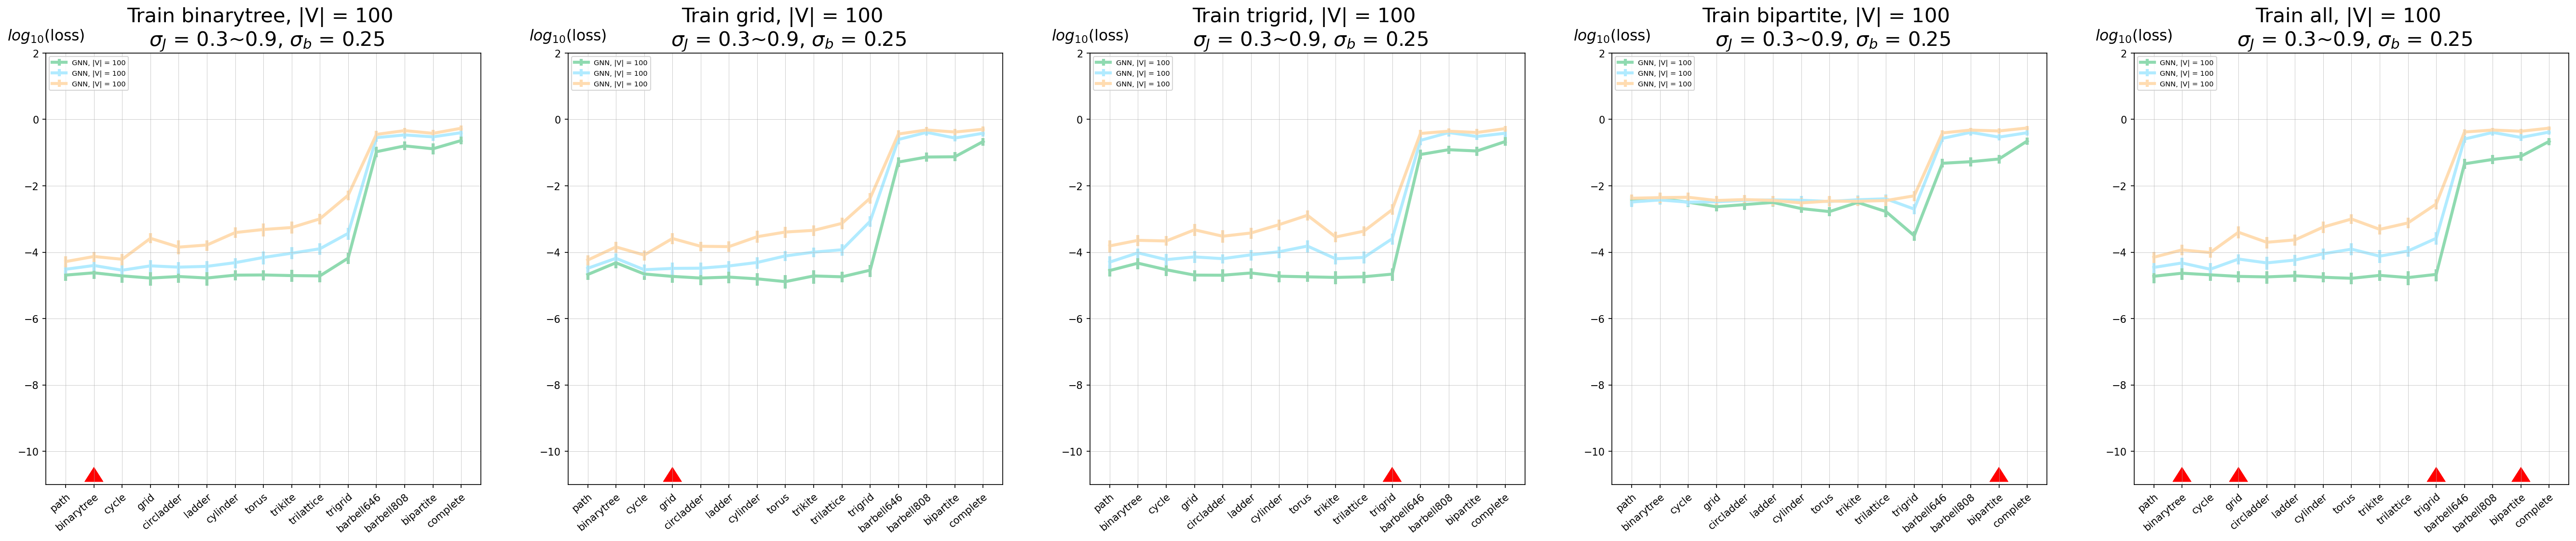

In [50]:
color_list=[
    ['#2e8b57','#3db773','#63cb91','#8fdab0'],#green
    ['#00bfff','#3bceff','#76ddff','#b1ebff'],#blue
    ['#ff8c00','#ffa73b','#ffc176','#ffdcb1'] #orange
]

cordinate = [
    [(0.7,-10.9),(1,-10.5),(1.3,-10.9)],
    [(2.7,-10.9),(3,-10.5),(3.3,-10.9)],
    [(9.7,-10.9),(10,-10.5),(10.3,-10.9)],
    [(12.7,-10.9),(13,-10.5),(13.3,-10.9)],
    []
]

Train_name = ['binarytree', 'grid', 'trigrid', 'bipartite', 'all']
algo_name = ['BP', "MF", "TRW"]
color_black = ['#000000','#474747','#7a7a7a','#adadad'] 
color_red = ['#ff2727','#ff6262','#ff9d9d','#ffd8d8'] 


fig = plt.figure(figsize = (45,90), dpi = 150)
for sigma, sigma_color, sigma_value in zip(range(3), color_list, [0.3, 0.6, 0.9]):      
    for train, train_index in zip(range(5), [1, 3, 10, 13, 0]):
        for algo in range(1):
            ax = fig.add_subplot(9,5,train+1)
#             plt.title("Train {}\n $\sigma_J$ = {}, $\sigma_b$ = 0.25".format(Train_name[train], sigma_value), fontsize = 20)
            for node, num_node in zip([3], [100]):
                plt.title("Train {}, |V| = {} \n $\sigma_J$ = 0.3~0.9, $\sigma_b$ = 0.25".format(Train_name[train], num_node), fontsize = 20)
#                 if train==4:
                    
#                     plt.errorbar(np.arange(15), loss1[sigma, train, 0, node, :], [error_min1[sigma, train, 0, node, :], error_max1[sigma, train, 0, node, :]], color = '#adadad', lw=3, label='GNN, {}'.format(Train_name[train]), zorder=0)
                    
#                     for i in [1,3,10,13]:
#                         plt.scatter(i, loss1[sigma, train, 0, node, i], marker = 'X', s=150, color = '#adadad', linewidths=0.01, zorder=1)
                    
#                 else:
#                     plt.scatter(train_index, loss1[sigma, train, 0, node, train_index], marker = 'X', s=150, color = sigma_color[node], linewidths=0.01, zorder=1)

                plt.errorbar(np.arange(15), loss1[sigma, train, 0, node, :], [error_min1[sigma, train, 0, node, :], error_max1[sigma, train, 0, node, :]], color = sigma_color[node], lw=3, label='GNN, |V| = {}'.format(num_node), zorder=0)
                
                
#                 plt.errorbar(np.arange(15), loss2[sigma, train, 0, node, :], [error_min2[sigma, train, 0, node, :], error_max2[sigma, train, 0, node, :]], color = sigma_color[node], lw=3, label='GNN, num_node={}_att'.format(num_node), linestyle = '--')
                
#                 plt.errorbar(np.arange(15), loss1[sigma, train, algo+1, node, :], [error_min1[sigma, train, algo+1, node, :], error_max1[sigma, train, algo+1, node, :]], color = color_black[node], lw=0.5, label='{}, num_node={}'.format(algo_name[algo],num_node))


                plt.ylim(-11,2)
                plt.xticks(np.arange(15), ['path','binarytree', 'cycle', 'grid', 'circladder', 'ladder', 'cylinder', 'torus', 'trikite', 'trilattice', 'trigrid', 'barbell646', 'barbell808', 'bipartite', 'complete'],fontsize=10,rotation =40,ha='right',rotation_mode="anchor")
                plt.ylabel("$log_{10}$(loss)",rotation=0,fontsize=15)
                ax.yaxis.set_label_coords(0,1.02)

                if train == 4:
                    for _ in range(4):
                        ax.add_patch(Polygon(cordinate[_], closed=True,fill=True,color='red'))
                else:
                    ax.add_patch(Polygon(cordinate[train], closed=True,fill=True,color='red'))
                    
                plt.grid(lw=0.3)
                plt.legend(loc=2, fontsize=7)
                
plt.subplots_adjust(hspace = 0.3)
fig.savefig("Elements/exp1_result_{}_sigma.pdf".format(num_node), bbox_inches='tight')